# 0. hugging face login

- google/gemma-2-2b-it 를 사용하기 위해서는 huggingface에서 google/gemma-2-2b-it 사용 권한을 가진 계정으로 로그인 해야 사용할 수 있음. 무료이고 클릭 한번으로 쉽게 사용권한을 얻을 수 잇다.

- notebook_login() 실행 후 나오는 입력창에 google/gemma-2-2b-it사용허가를 받은 계정의 huggingface API 토큰을 입력해 주세요.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

# 1. data 가져오기

In [3]:
%%capture
!wget https://aistages-api-public-prod.s3.amazonaws.com/app/Competitions/000291/data/data.tar.gz
!tar -xzvf data.tar.gz

In [4]:
import json
import pandas as pd
from IPython.display import display

data_list = []

with open('data/documents.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        data_list.append(data)

df = pd.DataFrame(data_list)

print("데이터 총 개수 :", len(df))
print("데이터 column:", df.columns)
display("예시 데이터 :", df.head(3))
print("\n데이터 결측치")

df[df.isnull()].count()

데이터 총 개수 : 4272
데이터 column: Index(['docid', 'src', 'content'], dtype='object')


'예시 데이터 :'

,docid,src,content
0,42508ee0-c543-4338-878e-d98c6babee66,ko_mmlu__nutrition__test,건강한 사람이 에너지 균형을 평형 상태로 유지하는 것은 중요합니다. 에너지 균형은 ...
1,4a437e7f-16c1-4c62-96b9-f173d44f4339,ko_mmlu__conceptual_physics__test,"수소, 산소, 질소 가스의 혼합물에서 평균 속도가 가장 빠른 분자는 수소입니다. 수..."
2,d3c68be5-9cb1-4d6e-ba18-5f81cf89affb,ko_ai2_arc__ARC_Challenge__test,종이와 플라스틱은 재활용 가능한 자원입니다. 중학교 과학 수업에서 우리는 종이와 플...



데이터 결측치


docid      0
src        0
content    0
dtype: int64

# 2. chunk 유효성 판단.

## 2-1. 토큰수 분석하기

- 각 청크가 비슷한 크기로 잘려 있는지 확인하기 위해서 토큰으로 나눠서 각 청크의 토큰 수, 평균, 분산 확인하기

- 토큰 수 분포표 와 IQR 그래프 시각화 하기

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# 원하는 토크나이저 가져오기
# 예시는 goolg/gemma모델 사용
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
import numpy as np

# 토큰 수 카운팅 함수
def count_tokens(sample):
    return len(tokenizer.tokenize(sample['content']))

df['token_count'] = df.apply(count_tokens, axis=1)
token_mean = np.mean(df['token_count'])
token_var = np.var(df['token_count'])

outlier_cnt = 0
IQR_1 = np.percentile(df['token_count'], 25)
IQR_3 = np.percentile(df['token_count'], 75)
IQR = IQR_3 - IQR_1

# 토큰 수 기반 outlier
token_count_outliers = []
for idx, item in df.iterrows():
    token_count = item['token_count']
    is_outlier = 0 # 0: 정상 / 1: high_outlier / 2: low_outlier

    # 상위 이상치
    if token_count > IQR_3 + 1.5 * IQR:
        is_outlier = 1
        outlier_cnt += 1

    # 하위 이상치
    elif token_count < IQR_1 - 1.5 * IQR:
        is_outlier = 2
        outlier_cnt += 1

    token_count_outliers.append(is_outlier)

df['token_count_outlier'] = token_count_outliers
outlier_rate = outlier_cnt / len(df)

print("토큰 수 평균 :", token_mean)
print("토큰 수 분산 :", token_var)
print("IQR 이상치 개수 :", outlier_cnt)
print("IQR 이상치 비율 : ", outlier_rate)


토큰 수 평균 : 204.07303370786516
토큰 수 분산 : 4548.216576189867
IQR 이상치 개수 : 180
IQR 이상치 비율 :  0.042134831460674156


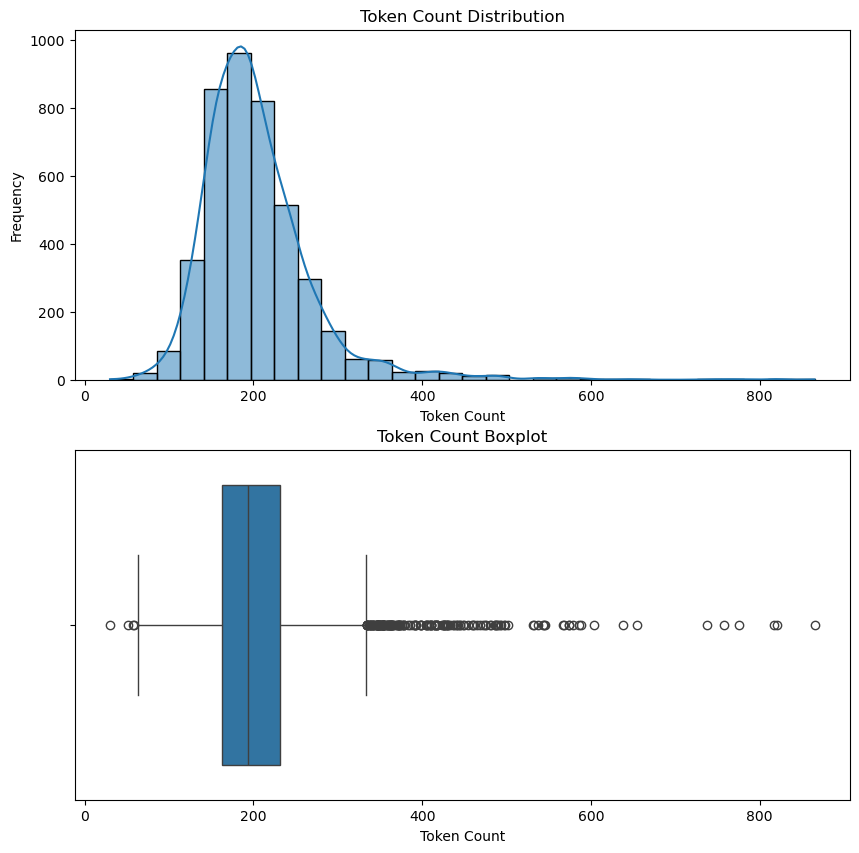

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
sns.histplot(df['token_count'], kde=True, bins=30)
plt.title('Token Count Distribution')
plt.xlabel('Token Count')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2)
sns.boxplot(x=df['token_count'])
plt.title('Token Count Boxplot')
plt.xlabel('Token Count')
plt.show()

## 2-2. 문장 유사도

- 청크를 문장 단위로 잘라서 모든 문장의 쌍의 유사도를 계산한다. 모든 문장 쌍이 유사한 문맥으로 구성되어 있는지 확인한다.

- 한국어 문장쌍의 유사도 값을 구하기 위해서 KR-SBERT를 사용하였다. SBERT는 일반 BERT보다 문장간의 유사도 구하는 것에 특화되어 있다.

In [12]:
from sentence_transformers import SentenceTransformer, util
import torch
from tqdm import tqdm
import re

# SBERT가 문장 쌍의 유사도 측정에 특화되어 있습니다.
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS').to(device)
tqdm.pandas()

# Chunk를 문장단위로 나누는 함수
def split_sentence(text):
    sentences = re.split(r'[.!?]', text)
    return [sent.strip() for sent in sentences if sent.strip() != '']

# 문장 쌍의 유사도를 측정하는 함수
def similarity_score(sample):
    content = sample['content']
    sentences = split_sentence(content)

    embeddings = model.encode(sentences, convert_to_tensor=True).to(device)

    similarity_scores = []

    for i in range(len(sentences)):
        for j in range(i+1, len(sentences)):
            similarity = util.pytorch_cos_sim(embeddings[i], embeddings[j])
            similarity_scores.append(similarity.item())

    chunk_similarity = np.mean(similarity_scores)

    return chunk_similarity

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
df['chunk_similarity_score'] = df.progress_apply(similarity_score, axis=1)

chunk_sim_score_mean = np.mean(df['chunk_similarity_score'])
chunk_sim_outlier_cnt = 0
chunk_sim_outliers = []

for idx, item in df.iterrows():
    chunk_sim_score = item['chunk_similarity_score']
    is_outlier = False

    if chunk_sim_score < 0.3:
        chunk_sim_outlier_cnt += 1
        is_outlier = True

    chunk_sim_outliers.append(is_outlier)

df['chunk_similarity_outlier'] = chunk_sim_outliers
print("chunk simillarity score : ", chunk_sim_score_mean)
print("chunk simillarity outlier cnt : ", chunk_sim_outlier_cnt)
print("chunk simillarity outlier rate : ", chunk_sim_outlier_cnt / len(df))

 31%|███▏      | 1338/4272 [00:25<00:58, 50.17it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 4272/4272 [01:18<00:00, 54.17it/s]


chunk simillarity score :  0.6063669604994832
chunk simillarity outlier cnt :  6
chunk simillarity outlier rate :  0.0014044943820224719


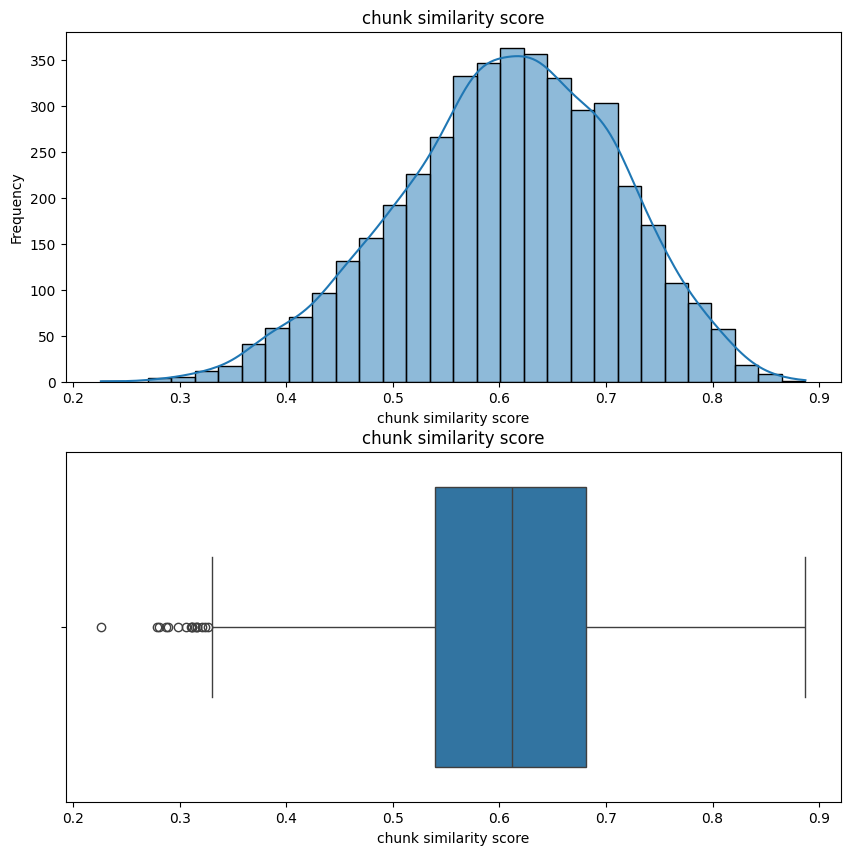

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
sns.histplot(df['chunk_similarity_score'], kde=True, bins=30)
plt.title('chunk similarity score')
plt.xlabel('chunk similarity score')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2)
sns.boxplot(x=df['chunk_similarity_score'])
plt.title('chunk similarity score')
plt.xlabel('chunk similarity score')
plt.show()


# 2-3. 토픽 일관성

- LDA를 사용하여 문서가 포함하고 있는 토픽의 비율을 판단합니다.
- n은 400(약 10%) 로 설정합니다.
- 결과값을 시각화 합니다.

#### 토픽 일관성 측정 방법
1. `문서 전처리` : Okt 형태소 분석기를 활용해서 명사(Noun) 형용사(Adjective), 동사(Verb)만 추출합니다.
2. `Vocab 만들기` : gensim의 Copora를 이용하여 문서에 등장하는 단어들만 모아서 vocab을 만듭니다.
3. `copora만들기` : 문서를 vocab의 고유 id로 바꿔줍니다.
4. `LDA 모델 학습` : id로 표현된 문서를 사용하여 LDA 학습을 시작합니다.
5. `토픽 무질서도(엔트로피) 측정` : 하나의 문서에 토픽이 몇 개 들어있는지, 어느 비율로 들어있는지를 LDA를 통해서 구해냈으니 해당 값을 활용하여 엔트로피를 계산합니다.
6. `outlier 판별`


In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from konlpy.tag import Okt
import numpy as np
from tqdm import tqdm
import math

In [ ]:
# 1. 문서 전처리
okt = Okt()
raw_documents = df['content'].tolist()

def preprocess(text):
    morphemes = okt.pos(text)
    result = [word for word, pos in morphemes if pos in ['Noun', 'Adjective', 'Verb']]
    return result

documents = [preprocess(doc) for doc in tqdm(raw_documents)]

100%|██████████| 4272/4272 [01:57<00:00, 36.51it/s]


In [ ]:
# 2. Vocab 만들기
dictionary = corpora.Dictionary(documents)

# 3. copora 만들기
corpus = [dictionary.doc2bow(doc) for doc in documents]

# 4. LDA 모델 훈련
num_topics = 400
lda_model = LdaModel(corpus = corpus,
                     id2word = dictionary,
                     num_topics = num_topics,
                     random_state = 42,
                     update_every = 1,
                     chunksize = 100,
                     passes = 10,
                     alpha = 'auto',
                     per_word_topics = True)


In [ ]:
# 5. 토픽 엔트로피 측정
def get_document_topics(doc_corpus):
    topic_distribution = lda_model.get_document_topics(doc_corpus)
    sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse = True)

    return sorted_topics

def calculate_entropy(topic_distribution):
    probabilities = [prob for topic_id, prob in topic_distribution if prob > 0]
    entropy = -sum(p * math.log2(p) for p in probabilities)
    return entropy

entropies = []
entropies_outlier = []
for corp in corpus:
    topic_distribution = get_document_topics(corp)
    entropy = calculate_entropy(topic_distribution)
    entropies.append(entropy)

    # 토픽 무질서도(엔트로피) 이상치
    if entropy > 4.2:
        entropy_outlier = True
    else:
        entropy_outlier = False
    entropies_outlier.append(entropy_outlier)

df['topic_entropy'] = entropies
df['topic_entropy_outlier'] = entropies_outlier

In [ ]:
df.head(3)

,docid,src,content,token_count,token_count_outlier,chunk_similarity_score,chunk_similarity_outlier,topic_entropy,topic_entropy_outlier
0,42508ee0-c543-4338-878e-d98c6babee66,ko_mmlu__nutrition__test,건강한 사람이 에너지 균형을 평형 상태로 유지하는 것은 중요합니다. 에너지 균형은 ...,251,0,0.641247,False,2.739792,False
1,4a437e7f-16c1-4c62-96b9-f173d44f4339,ko_mmlu__conceptual_physics__test,"수소, 산소, 질소 가스의 혼합물에서 평균 속도가 가장 빠른 분자는 수소입니다. 수...",147,0,0.827363,False,3.397764,False
2,d3c68be5-9cb1-4d6e-ba18-5f81cf89affb,ko_ai2_arc__ARC_Challenge__test,종이와 플라스틱은 재활용 가능한 자원입니다. 중학교 과학 수업에서 우리는 종이와 플...,316,0,0.511206,False,2.850605,False


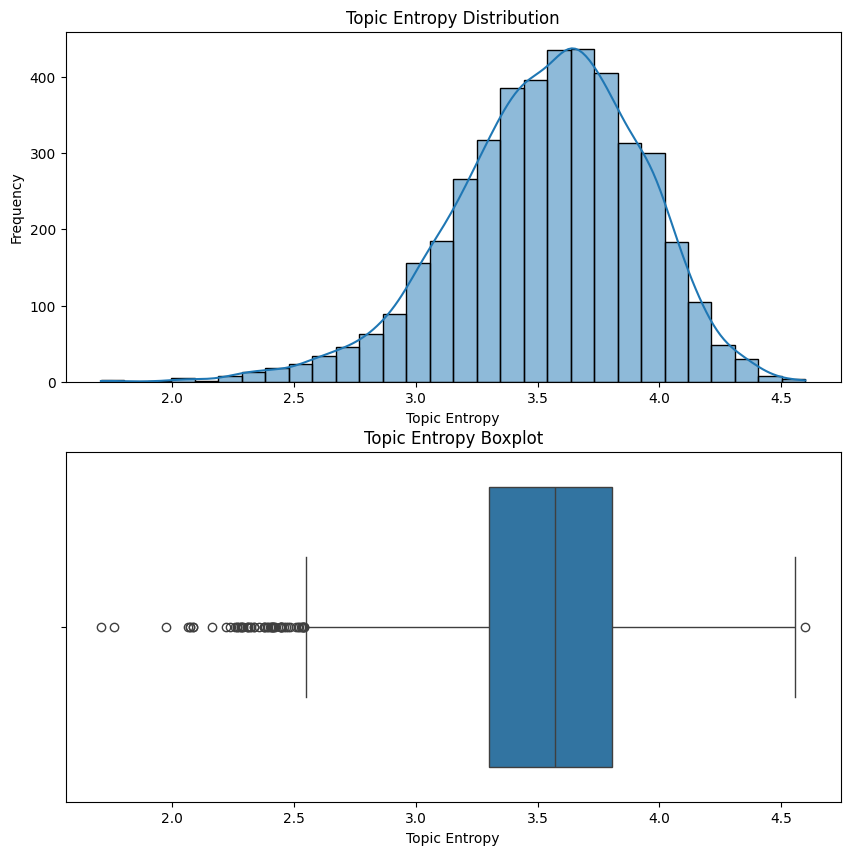

In [ ]:
# 토픽 엔트로피 시각화
entropy = df['topic_entropy']

plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
sns.histplot(entropy, kde=True, bins=30)
plt.title('Topic Entropy Distribution')
plt.xlabel('Topic Entropy')
plt.ylabel('Frequency')

plt.subplot(2,1,2)
sns.boxplot(x=entropy)
plt.title('Topic Entropy Boxplot')
plt.xlabel('Topic Entropy')
plt.show()

# Outlier들 정성평가
- IQR 기준 outlier로 판단되는 데이터들을 직접 읽어보고 평가해보자.

1. 토큰수 outlier
2. 문장 유사도 outlier
3. 토픽 일관성 outlier


In [ ]:
# 토큰수 outlier 정성평가
token_outlier = df[df['token_count_outlier'] == 1].sort_values(by='token_count', ascending=False)
for idx, row in token_outlier.iterrows():
    sentences = split_sentence(row['content'])

    print("토큰 수 : ", row['token_count'])
    for sent in sentences:
        print(sent)
    print("-" * 100)

토큰 수 :  865
기체의 분자 질량은 해당 기체의 밀도와 온도에 따라 결정됩니다
이 문제에서는 26
0 °C, 722 토르에서 밀도가 2
05 g/L인 기체의 분자 질량을 구해야 합니다
분자 질량은 기체의 질량을 분자의 개수로 나눈 값입니다
따라서, 우리는 주어진 밀도와 온도를 사용하여 기체의 질량을 구할 수 있습니다
먼저, 밀도를 사용하여 기체의 질량을 구하는 공식은 다음과 같습니다
질량 = 밀도 x 부피

주어진 밀도는 2
05 g/L이므로, 부피를 알아야 합니다
부피는 온도와 압력에 따라 변할 수 있습니다
따라서, 주어진 온도와 압력을 사용하여 부피를 구해야 합니다
온도는 26
0 °C로 주어졌으므로, 이를 켈빈 온도로 변환해야 합니다
켈빈 온도는 섭씨 온도에 273
15를 더한 값입니다
따라서, 주어진 온도를 켈빈 온도로 변환하면 26
0 + 273
15 = 299
15 K입니다
압력은 722 토르로 주어졌으므로, 이를 기압으로 변환해야 합니다
기압은 토르를 대기압으로 나눈 값입니다
대기압은 보통 760 토르로 가정합니다
따라서, 주어진 압력을 기압으로 변환하면 722 / 760 = 0
95 atm입니다
이제 주어진 온도와 압력을 사용하여 부피를 구할 수 있습니다
부피는 기체의 상태 방정식을 사용하여 구할 수 있습니다
상태 방정식은 다음과 같습니다
PV = nRT

여기서 P는 압력, V는 부피, n은 몰의 수, R은 기체 상수, T는 온도입니다
주어진 압력과 온도를 사용하여 부피를 구하기 위해, 상태 방정식을 다음과 같이 변형할 수 있습니다
V = (nRT) / P

기체 상수 R은 0
0821 L·atm/(mol·K)입니다
따라서, 주어진 압력과 온도를 사용하여 부피를 구하면 다음과 같습니다
V = (n x 0
0821 x 299
15) / 0
95

주어진 밀도와 부피를 사용하여 기체의 질량을 구하면 다음과 같습니다
질량 = 2
05 x ((n x 0
0821 x 299
15) / 0
95)

주어진 기체의 분자 질량은 53
0 g/mol이므로

In [ ]:
# 문장 유사도 outlier 정성평가
token_outlier = df[df['chunk_similarity_outlier'] == True].sort_values(by='chunk_similarity_score')
for idx, row in token_outlier.iterrows():
    sentences = split_sentence(row['content'])

    print(f"문장 유사도 : {row['chunk_similarity_score']:.4f}")
    for sent in sentences:
        print(sent)
    print("-" * 100)

문장 유사도 : 0.2258
미국 내에서는 2018년 현재, 알고리즘을 통한 의사 결정이 가석방을 위한 범죄 위험 평가에 불합리하게 적용되고 있다는 주장이 있습니다
이 주장을 제기한 사람들은 대략 56% 정도입니다
이러한 주장은 알고리즘의 판단이 인간의 판단과 다를 수 있으며, 이로 인해 잘못된 결정이 이루어질 수 있다는 우려를 나타냅니다
이에 대한 논의와 개선이 필요하다는 의견도 제기되고 있습니다
----------------------------------------------------------------------------------------------------
문장 유사도 : 0.2781
사하라 이남 아프리카 지역에서는 2020년 현재, 인구의 약 40%가 $1
90 미만으로 생활하고 있습니다
이 지역은 경제적으로 어려운 상황에 처해 있으며, 많은 사람들이 극도의 가난과 식량 부족에 직면하고 있습니다
이러한 상황은 사회적 불평등과 인간의 기본적인 생존권을 침해하는 문제로 여겨집니다
이에 대한 국제사회의 관심과 지원이 필요합니다
사하라 이남 아프리카 지역의 인구 중 40%가 $1
90 미만으로 생활하는 것은 심각한 문제이며, 이를 해결하기 위해 국제적인 노력이 필요합니다
----------------------------------------------------------------------------------------------------
문장 유사도 : 0.2802
의학 수업에서 147명의 학생이 있었고, 생화학 기말 시험 점수의 분포에 대한 여러 통계적 정보가 주어졌다
이 시험의 평균은 67점이었고, 중앙값은 76점이었다
또한, 최빈값은 80점이었고, 표준 편차는 5
5이며, 분산은 30
25였다
그러나 세 명의 학생은 예정된 날짜에 시험을 볼 수 없어 1주일 후에 다른 형태의 시험을 보았다
이에 따라 생화학 시험 점수의 분포에 대한 중심 경향을 가장 편향되지 않은 추정치를 구해야 한다
이 문제에서 가장 편향되지 않은 추정치는 평균이

In [ ]:
# 토픽 일관성 outlier 정성평가
token_outlier = df[df['topic_entropy_outlier'] == True].sort_values(by='topic_entropy', ascending=False)
for idx, row in token_outlier.iterrows():
    sentences = split_sentence(row['content'])

    print("토픽 무질서도 점수 : ", row['topic_entropy'])
    for sent in sentences:
        print(sent)
    print("-" * 100)

토픽 무질서도 점수 :  4.59837978343897
석탄은 지구의 지각 변동과 생물의 분해 과정을 거쳐 형성된 고대 유기 화합물입니다
이러한 석탄은 주로 탄소, 수소, 산소, 질소 등의 원소로 구성되어 있습니다
그 중에서도 석탄 샘플에서 가장 발견하기 어려운 원소는 은입니다
은은 석탄 내부에서 매우 희박하게 분포되어 있으며, 그 특성으로 인해 발견하기 어렵습니다
석탄은 에너지 생산과 산업 분야에서 중요한 역할을 하고 있으며, 은의 희소성은 석탄의 가치를 더욱 높이고 있습니다
석탄은 우리 삶에 많은 영향을 미치는 자원이며, 은의 발견은 석탄 연구에 새로운 가능성을 열어줄 수 있습니다
----------------------------------------------------------------------------------------------------
토픽 무질서도 점수 :  4.554553055917683
라틴계 미국인들 사이에서의 HIV 유병률은 아프리카계 미국인을 제외한 모든 다른 민족 집단보다 높습니다
이는 연구와 조사에 의해 확인된 사실입니다
라틴계 미국인들은 HIV에 노출되는 위험이 더 높은 환경에서 살고 있으며, 예방 및 치료에 대한 접근성이 제한되는 경우가 많습니다
이러한 상황은 라틴계 미국인들의 건강과 복지에 부정적인 영향을 미치고 있습니다
따라서, 라틴계 미국인들을 대상으로 한 예방 및 교육 프로그램의 중요성이 강조되고 있으며, 이를 통해 HIV 유병률을 낮추는 노력이 진행되고 있습니다
그러나 여전히 많은 과제와 도전이 남아있으며, 사회적, 경제적, 문화적인 요인들을 고려한 종합적인 대책이 필요합니다
라틴계 미국인들의 건강과 복지를 보호하고 개선하기 위해 지속적인 노력이 필요합니다
----------------------------------------------------------------------------------------------------
토픽 무질서도 점수 :  4.509226099589497
고원이 형성되는 

In [ ]:
all_condition_outlier = df[(df['chunk_similarity_outlier'] == True) &
                           (df['token_count_outlier'] == 1) &
                           (df['topic_entropy_outlier'] == True)]

token_similarity_outlier = df[(df['chunk_similarity_outlier'] == True) &
                           (df['token_count_outlier'] == 1)]

token_entropy_outlier = df[(df['token_count_outlier'] == 1) &
                           (df['topic_entropy_outlier'] == True)]

similarity_entropy_outlier = df[(df['chunk_similarity_outlier'] == True) &
                           (df['topic_entropy_outlier'] == True)]

print("모든 조건에서 outlier인 데이터 수 : ", len(all_condition_outlier))
print("토큰 수 + 문장 유사도 outlier 인 데이터 수 :", len(token_similarity_outlier))
print("토큰 수 + 토픽 일관성 outlier 인 데이터 수 :", len(token_entropy_outlier))
print("문장 유사도 + 토픽 일관성 outlier 인 데이터 수 :", len(similarity_entropy_outlier))

모든 조건에서 outlier인 데이터 수 :  0
토큰 수 + 문장 유사도 outlier 인 데이터 수 : 0
토큰 수 + 토픽 일관성 outlier 인 데이터 수 : 1
문장 유사도 + 토픽 일관성 outlier 인 데이터 수 : 0


In [ ]:
# 토큰 수 + 토픽 일관성 outlier 데이터 정성평가
text = token_entropy_outlier['content'].item()
sentences = split_sentence(text)

for sent in sentences:
    print(sent)


성 선택의 이론은 사회생물학자들이 특히 성별 차이의 진화를 설명하는 데 사용한다
성 선택은 동물들이 번식 파트너를 선택할 때 특정한 특성을 선호하는 경향을 말한다
이 이론은 동물들이 번식을 통해 자신의 유전자를 전달하는 데 있어서 어떤 특성이 유리한지를 설명한다
성 선택은 종 내에서 성별 차이를 유발하며, 이는 종의 진화에 영향을 미친다
성 선택은 동물들이 번식 파트너를 선택할 때 주로 성적으로 끌리는 특성을 선호하는 경향을 말한다
이는 종 내에서 특정한 특성이 더 많이 나타나게 되는 원인이 된다
성 선택은 동물들이 번식을 통해 자신의 유전자를 전달하는 데 있어서 어떤 특성이 유리한지를 설명한다
이는 종의 진화에 영향을 미치며, 종 내에서 성별 차이를 유발한다
성 선택은 동물들이 번식 파트너를 선택할 때 특정한 특성을 선호하는 경향을 말한다
이는 종 내에서 특정한 특성이 더 많이 나타나게 되는 원인이 된다
성 선택은 동물들이 번식을 통해 자신의 유전자를 전달하는 데 있어서 어떤 특성이 유리한지를 설명한다
이는 종의 진화에 영향을 미치며, 종 내에서 성별 차이를 유발한다
